# Stack Overflow Data EDA
- Joel Stremmel
- 01-05-20

**About:**
This notebook explores the Stack Overflow data available through `tff.simulation.datasets` with some basic EDA and then by training a model with Federared Averaging by following the Federated Learning for Text Generation example notebook listed in the references section.

**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/

### Setup

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow_federated
# !pip install --upgrade tensorflow-nightly-gpu
# !pip install --upgrade nltk
# !pip install matplotlib
# !pip install nest_asyncio

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import collections
import functools
import os
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [4]:
import tensorflow as tf
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))

Built with Cuda: True
Build with GPU support: True


In [5]:
import tensorflow_federated as tff

In [6]:
tf.compat.v1.enable_v2_behavior()

In [7]:
np.random.seed(0)

### Test TFF

In [8]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Load Stack Overflow Word Counts

In [9]:
word_counts = tff.simulation.datasets.stackoverflow.load_word_counts(cache_dir='~/data')

### Number of Words

In [10]:
len(word_counts)

6005329

### Create Dictionary of Counts

In [11]:
count_dict = collections.Counter(word_counts)

### Create Function to Plot Word Frequency

In [12]:
def plot_ordered_frequency(count_dict, n, color='orange'):
    
    top_words = collections.OrderedDict(sorted(count_dict.most_common(n), key=lambda x: x[1]))
    
    plt.figure(figsize=(8, 16))
    plt.barh(range(len(top_words)), top_words.values(), align='center', color=color)
    plt.yticks(range(len(top_words)), list(top_words.keys()))
    
    plt.title('Most Common Words', size=18)
    plt.xlabel('Count of Occurences', size=18)
    plt.ylabel('Words', size=18)

    plt.show()

### Plot Raw Frequency of Words

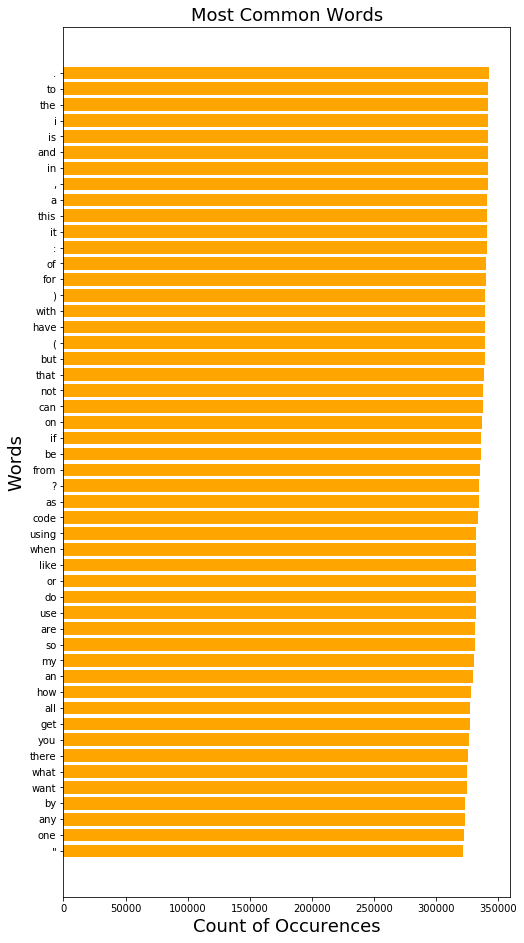

In [13]:
plot_ordered_frequency(count_dict, n=50)

### Clean Dictionary by:
- Removing Stopwords
- Removing Punctuation

In [14]:
for stopword in stopwords.words('english'):
    count_dict.pop(stopword, None)

In [15]:
for punctuation in string.punctuation:
    count_dict.pop(punctuation, None)

### Plot Frequency of Filtered Words

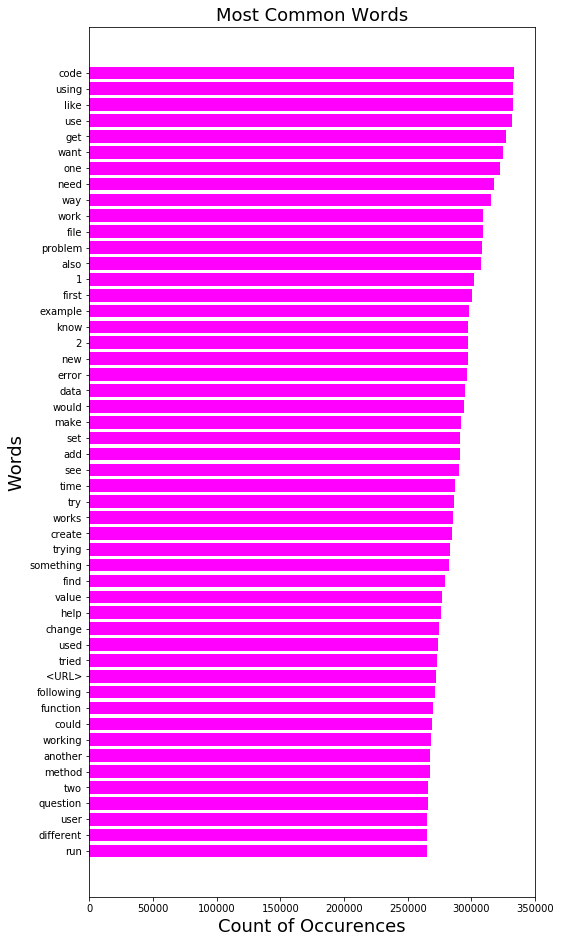

In [16]:
plot_ordered_frequency(count_dict, n=50, color='magenta')

### View Some Rare Words

In [17]:
count_dict.most_common()[-10:-1]

[('zzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 1)]

### Compute Summary Statistics

In [18]:
counts = list(count_dict.values())
min_occurences = min(counts)
max_occurences = max(counts)
mean_occurences = np.mean(counts)
median_occurences = np.median(counts)
stdv_occurences = np.std(counts)
print('Minimum number of occurences: {}'.format(min_occurences))
print('Maximum number of occurences: {}'.format(max_occurences))
print('Mean number of occurences: {}'.format(round(mean_occurences, 3)))
print('Median number of occurences: {}'.format(round(median_occurences, 3)))
print('Standard Deviation of occurences: {}'.format(round(stdv_occurences, 3)))

Minimum number of occurences: 1
Maximum number of occurences: 333526
Mean number of occurences: 45.946
Median number of occurences: 1.0
Standard Deviation of occurences: 1946.294


### Plot Histogram of Counts
- First with the raw counts
- Then with the log of the counts due to the increasingly small number of large values

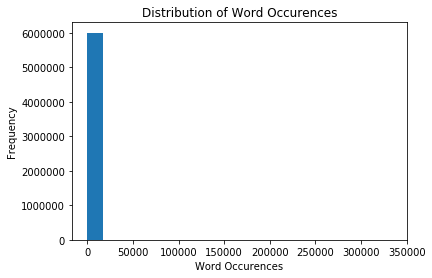

In [19]:
plt.hist(counts, bins=20)
plt.title('Distribution of Word Occurences')
plt.xlabel('Word Occurences')
plt.ylabel('Frequency')
plt.show()

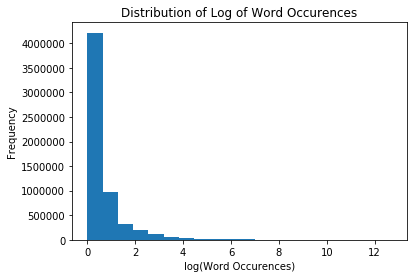

In [20]:
fig, ax = plt.subplots(1,1)
plt.hist(np.log(counts), bins=20)
plt.title('Distribution of Log of Word Occurences')
plt.xlabel('log(Word Occurences)')
plt.ylabel('Frequency')
plt.show()

### Load Stack Overflow Data

In [21]:
train_data, val_data, test_data = tff.simulation.datasets.stackoverflow.load_data(cache_dir='~/data')
print(train_data.output_shapes)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


OrderedDict([('creation_date', TensorShape([])), ('score', TensorShape([])), ('tags', TensorShape([])), ('title', TensorShape([])), ('tokens', TensorShape([])), ('type', TensorShape([]))])


### Example Number of Clients

In [22]:
print('{} train clients.'.format(len(train_data.client_ids)))
print('{} val clients.'.format(len(val_data.client_ids)))
print('{} test clients.'.format(len(test_data.client_ids)))

342477 train clients.
38758 val clients.
204088 test clients.


### View Samples

In [23]:
raw_example_dataset = train_data.create_tf_dataset_for_client('00000001')
for record in raw_example_dataset.take(2):
    for key in record:
        print('\nKey: {}'.format(key))
        print(record[key])


Key: creation_date
tf.Tensor(b'2008-12-22 14:45:37.037 UTC', shape=(), dtype=string)

Key: score
tf.Tensor(11, shape=(), dtype=int64)

Key: tags
tf.Tensor(b'sql-server|indexing', shape=(), dtype=string)

Key: title
tf.Tensor(b'what fields should be indexed on a given table ?', shape=(), dtype=string)

Key: tokens
tf.Tensor(b'the sql server 2008 management studio query tool , if you turn on " include actual execution plan " , will tell you what indexes a given query needs to run fast .', shape=(), dtype=string)

Key: type
tf.Tensor(b'answer', shape=(), dtype=string)

Key: creation_date
tf.Tensor(b'2008-12-22 14:45:37.037 UTC', shape=(), dtype=string)

Key: score
tf.Tensor(11, shape=(), dtype=int64)

Key: tags
tf.Tensor(b'sql-server|indexing', shape=(), dtype=string)

Key: title
tf.Tensor(b'what fields should be indexed on a given table ?', shape=(), dtype=string)

Key: tokens
tf.Tensor(b"( assuming there's an obvious missing index that is making the query run unusually slow , that is .

### Set Vocabulary
- Currently using the fixed vocabularly of ASCII chars that occur in the works of Shakespeare and Dickens
- **Is there a good way to get the distinct characters from a TF dataset?**

In [24]:
vocab = list('dhlptx@DHLPTX $(,048cgkoswCGKOSW[_#\'/37;?bfjnrvzBFJNRVZ"&*.26:\naeimquyAEIMQUY]!%)-159\r')

### Creating a Mapping from Unique Characters to Indices

In [25]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

### Load and Generate Text with a Pre-Trained Model

In [26]:
def load_model(batch_size):
    
    urls = {
        1: 'https://storage.googleapis.com/tff-models-public/dickens_rnn.batch1.kerasmodel',
        8: 'https://storage.googleapis.com/tff-models-public/dickens_rnn.batch8.kerasmodel'}
    
    assert batch_size in urls, 'batch_size must be in ' + str(urls.keys())
    url = urls[batch_size]
    local_file = tf.keras.utils.get_file(os.path.basename(url), origin=url)  
    
    return tf.keras.models.load_model(local_file, compile=False)

In [27]:
def generate_text(model, start_string):
    
    # From https://www.tensorflow.org/tutorials/sequences/text_generation
    num_generate = 200
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [28]:
# Text generation requires a batch_size=1 model.
keras_model_batch1 = load_model(batch_size=1)
print(generate_text(keras_model_batch1, 'What of TensorFlow Federated, you ask? '))

What of TensorFlow Federated, you ask? Sany night, The Vengeance when they slip in her peast, that the
barrier was a deapons attempted on earnest to
itself, on the neighbour, and the three hundred and eight Guilly reliance over their sea


### Preprocess Federated Stack Overflow

In [29]:
SEQ_LENGTH = 100
BATCH_SIZE = 8 # Use the batch size 8 rnn trained on Dickens
BUFFER_SIZE = 10000  # For dataset shuffling

In [30]:
# Using a namedtuple with keys x and y as the output type of the
# dataset keeps both TFF and Keras happy:
BatchType = collections.namedtuple('BatchType', ['x', 'y'])

# Construct a lookup table to map string chars to indexes,
# using the vocab loaded above:
table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys=vocab,
                                                                      values=tf.constant(list(range(len(vocab))),
                                                                      dtype=tf.int64)),
                                  default_value=0)

In [31]:
def to_ids(x):
    s = tf.reshape(x['tokens'], shape=[1])
    chars = tf.strings.bytes_split(s).values
    ids = table.lookup(chars)
    return ids

In [32]:
def split_input_target(chunk):
    input_text = tf.map_fn(lambda x: x[:-1], chunk)
    target_text = tf.map_fn(lambda x: x[1:], chunk)
    return BatchType(input_text, target_text)

In [33]:
def preprocess(dataset):
    return (
        # Map ASCII chars to int64 indexes using the vocab
        dataset.map(to_ids)
        # Split into individual chars
        .unbatch()
        # Form example sequences of SEQ_LENGTH +1
        .batch(SEQ_LENGTH + 1, drop_remainder=True)
        # Shuffle and form minibatches
        .shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
        # And finally split into (input, target) tuples,
        # each of length SEQ_LENGTH.
        .map(split_input_target))

In [34]:
example_dataset = preprocess(raw_example_dataset)
print(tf.data.experimental.get_structure(example_dataset))

BatchType(x=TensorSpec(shape=(8, 100), dtype=tf.int64, name=None), y=TensorSpec(shape=(8, 100), dtype=tf.int64, name=None))


### Compile and Test on Preprocessed Data

In [35]:
class FlattenedCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):

    def __init__(self, name='accuracy', dtype=None):
        super(FlattenedCategoricalAccuracy, self).__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1, 1])
        y_pred = tf.reshape(y_pred, [-1, len(vocab), 1])
        return super(FlattenedCategoricalAccuracy, self).update_state(y_true, y_pred, sample_weight)

In [36]:
def compile(keras_model):
    keras_model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.05),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                                                           metrics=[FlattenedCategoricalAccuracy()])
    return keras_model

In [37]:
# Load and compile the models
keras_model = load_model(batch_size=BATCH_SIZE)
compile(keras_model)

# Confirm that loss is much lower on Stack Overflow than on random data
print('Evaluating on an example Stack Overflow character:')
keras_model.evaluate(example_dataset.take(1))

# As a sanity check, we can construct some completely random data, where we expect
# the accuracy to be essentially random:
random_indexes = np.random.randint(low=0, high=len(vocab), size=1 * BATCH_SIZE * (SEQ_LENGTH + 1))
data = {'tokens': tf.constant(''.join(np.array(vocab)[random_indexes]), shape=[1, 1])}
random_dataset = preprocess(tf.data.Dataset.from_tensor_slices(data))

print('\nExpected accuracy for random guessing: {:.3f}'.format(1.0 / len(vocab)))
print('Evaluating on completely random data:')
keras_model.evaluate(random_dataset, steps=1)

Evaluating on an example Stack Overflow character:
1/1 [==============================] - 1s 828ms/step - loss: 3.7817 - accuracy: 0.3725

Expected accuracy for random guessing: 0.012
Evaluating on completely random data:
1/1 [==============================] - 0s 268ms/step - loss: 11.4399 - accuracy: 0.0137


[11.439885139465332, 0.01375]

### Improve Model with Federated Averaging

In [38]:
# Clone the keras_model inside `create_tff_model()`, which TFF will
# call to produce a new copy of the model inside the graph that it will serialize.
def create_tff_model():
    # TFF uses a `dummy_batch` so it knows the types and shapes
    # that your model expects.
    x = tf.constant(np.random.randint(1, len(vocab), size=[BATCH_SIZE, SEQ_LENGTH]))
    dummy_batch = collections.OrderedDict([('x', x), ('y', x)]) 
    keras_model_clone = compile(tf.keras.models.clone_model(keras_model))
    return tff.learning.from_compiled_keras_model(keras_model_clone, dummy_batch=dummy_batch)

In [39]:
# This command builds all the TensorFlow graphs and serializes them: 
fed_avg = tff.learning.build_federated_averaging_process(model_fn=create_tff_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Run One Round of Federated Averaging

In [40]:
state = fed_avg.initialize()
state, metrics = fed_avg.next(state, [example_dataset.take(1)])
print(metrics)

<accuracy=0.0062500000931322575,loss=4.453789710998535>


### Get Sample Clients for Training

In [41]:
NUM_CLIENTS = 20

In [42]:
def get_sample_clients(dataset, num_clients):
    return np.array(dataset.client_ids)[np.random.choice(len(dataset.client_ids),
                                                         size=num_clients,
                                                         replace=False)]

In [43]:
train_clients = get_sample_clients(train_data, num_clients=NUM_CLIENTS)
test_clients = get_sample_clients(test_data, num_clients=NUM_CLIENTS)

### Build and Preprocess the Train and Test Datasets

In [44]:
def data(client, source=train_data):
    return preprocess(source.create_tf_dataset_for_client(client)).take(2)

In [45]:
train_datasets = [data(client) for client in train_clients]

# We concatenate the test datasets for evaluation with Keras.
test_dataset = functools.reduce(lambda d1, d2: d1.concatenate(d2), 
                                [data(client, test_data) for client in test_clients])

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Train with Federated Averaging

In [46]:
# NOTE: If the statement below fails, it means that you are
# using an older version of TFF without the high-performance
# executor stack. Call `tff.framework.set_default_executor()`
# instead to use the default reference runtime.
if six.PY3:
    tff.framework.set_default_executor(tff.framework.create_local_executor())

In [47]:
NUM_ROUNDS = 20

# The state of the FL server, containing the model and optimization state.
state = fed_avg.initialize()

state = tff.learning.state_with_new_model_weights(
    state,
    trainable_weights=[v.numpy() for v in keras_model.trainable_weights],
    non_trainable_weights=[v.numpy() for v in keras_model.non_trainable_weights]
)

def keras_evaluate(state, round_num):
    tff.learning.assign_weights_to_keras_model(keras_model, state.model)
    print('Evaluating before training round', round_num)
    keras_model.evaluate(example_dataset, steps=2)

for round_num in range(NUM_ROUNDS):
    keras_evaluate(state, round_num)
    # N.B. The TFF runtime is currently fairly slow,
    # expect this to get significantly faster in future releases.
    state, metrics = fed_avg.next(state, train_datasets)
    print('Training metrics: ', metrics)

keras_evaluate(state, NUM_ROUNDS + 1)

Evaluating before training round 0
2/2 [==============================] - 1s 317ms/step - loss: 3.4899 - accuracy: 0.3825
Training metrics:  <accuracy=0.40456250309944153,loss=3.496861219406128>
Evaluating before training round 1
2/2 [==============================] - 1s 312ms/step - loss: 3.6203 - accuracy: 0.4044
Training metrics:  <accuracy=0.4144062399864197,loss=3.458650588989258>
Evaluating before training round 2
2/2 [==============================] - 1s 314ms/step - loss: 3.5172 - accuracy: 0.4187
Training metrics:  <accuracy=0.4176875054836273,loss=3.4151408672332764>
Evaluating before training round 3
2/2 [==============================] - 1s 299ms/step - loss: 3.1471 - accuracy: 0.4525
Training metrics:  <accuracy=0.41574999690055847,loss=3.457104444503784>
Evaluating before training round 4
2/2 [==============================] - 1s 317ms/step - loss: 3.4382 - accuracy: 0.4156
Training metrics:  <accuracy=0.4231874942779541,loss=3.378187894821167>
Evaluating before training 

In [48]:
# Text generation requires batch_size=1
keras_model_batch1.set_weights([v.numpy() for v in keras_model.weights])
print(generate_text(keras_model_batch1, 'What of TensorFlow Federated, you ask?'))

What of TensorFlow Federated, you ask? Sydney Carton returning not to identh. What is is tht Extraor is for to-more co wip in yourself into
burning of the city controvulating versal like s got up with it is a shame was abso
business-wha


**Suggested extensions from tutorial:**

- Write a more realistic training loop where you sample clients to train on randomly.
- Use ".repeat(NUM_EPOCHS)" on the client datasets to try multiple epochs of local training (e.g., as in McMahan et. al.). See also Federated Learning for Image Classification which does this.
- Change the compile() command to experiment with using different optimization algorithms on the client.
- Try the server_optimizer argument to build_federated_averaging_process to try different algorithms for applying the model updates on the server.
- Try the client_weight_fn argument to to build_federated_averaging_process to try different weightings of the clients. The default weights client updates by the number of examples on the client, but you can do e.g. client_weight_fn=lambda _: tf.constant(1.0).